In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import torch
import numpy as np

# go back .. directory
import sys
sys.path.append("../")

from pipeline.config import Config
from pipeline.model_utils.model_factory import construct_model_base
from pipeline.run_pipeline import load_and_sample_datasets
from pipeline.run_pipeline import filter_data
from pipeline.submodules.generate_directions import get_mean_activations, get_activations_array
from pipeline.submodules.evaluate_loss import compute_loss_for_target_strings

In [2]:
model_path = "meta-llama/llama-2-7b-chat-hf"
model_alias = os.path.basename(model_path)
cfg = Config(model_alias=model_alias, model_path=model_path)
model_base = construct_model_base(cfg.model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [01:44<00:00, 52.02s/it]


In [3]:
# Load and sample datasets
harmful_train, harmless_train, harmful_val, harmless_val = load_and_sample_datasets(cfg)

Here, we load the precomputed refusal direction. 
This direction can be manually created by running `run_pipeline.py` and altering the datasets.

In [4]:
# load all refusal direction
refusal_direction = torch.load(f'{cfg.artifact_path()}/generate_directions/mean_diffs.pt') # n_pos, n_layer, d_model
# n_pos - NUMBER OF POSITIONS IN THE END OF EACH TOKENIZED PROMPT
refusal_direction_last = refusal_direction[-1, :, :].unsqueeze(0) # 1, n_layer, d_model

In [5]:
refusal_direction_last.shape

torch.Size([1, 32, 4096])

In [ ]:
#SETUP
LINE_WIDTH = 3
SMALL_SIZE = 15
SMALLER_SIZE = 12
MEDIUM_SIZE = 22
BIG_SIZE = 20
BIGGER_SIZE = 25
ALPHA = 0.3

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALLER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.axisbelow'] = True

'''cm=plt.get_cmap('CMRmap')
NUM_COLORS = len(all_papers)+1
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)][::-1]'''
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
colors = [(0, 0, 0), 
          (230, 25, 75), 
          (60, 180, 75), 
          (0, 130, 200), 
          (245, 130, 48),
          (145, 30, 180),
          (0, 100, 100), 
          (240, 50, 230), 
          (255, 200, 0),
          (0, 0, 128), 
          #special colors:
          (255, 255, 255), 
          (128, 128, 128),
          #seemingly bad:
          (250, 190, 190),  
          (128, 128, 0), 
          (255, 215, 180),
          (170, 255, 195), 
          (170, 110, 40), 
          (255, 250, 200), 
          (250, 190, 212),  
          (220, 190, 255), 
          (70, 240, 240), 
          (255, 250, 200),
          (170, 255, 195),
         ] 
colors = [[x[0]/255., x[1]/255., x[2]/255.] for x in colors]

colors_d = [[x[0]*0.75, x[1]*0.75, x[2]*0.75] for x in colors]
#Draw the plots without  marker
markers = ['s','D','h','>','o','p','*','x','+']


def get_refusal_cosine_similarities(instructions_activations, refusal_direction):
    """
    Calculate the cosine similarity between the last activations of the instructions and the refusal direction.
    """
    # calculate the cosine similarity for each instruction
    cosine_similarities = []
    for i in range(instructions_activations.shape[0]):
        # calculate the cosine similarity
        cosine_similarity = torch.nn.functional.cosine_similarity(instructions_activations[i], refusal_direction, dim=-1).squeeze().cpu().numpy()
        cosine_similarities.append(cosine_similarity)
    return cosine_similarities

def plot_refusal_similarity(refusal_direction_last, prompts_dict, batch_size=32):
    plt.figure(figsize=(10, 5))
    for group, prompts in prompts_dict.items():
        last_activations_prompts = get_activations_array(model_base.model, model_base.tokenizer, prompts,\
                                                            model_base.tokenize_instructions_fn, model_base.model_block_modules,\
                                                                batch_size=batch_size, positions=[-1])
        cosine_similarities = get_refusal_cosine_similarities(last_activations_prompts, refusal_direction_last)
        mean_cosine_similarities = np.mean(cosine_similarities, axis=0)
        std_cosine_similarities = np.std(cosine_similarities, axis=0)
        plt.plot(mean_cosine_similarities, linewidth=4, label=group)
        # plt.fill_between(range(len(mean_cosine_similarities)), mean_cosine_similarities - std_cosine_similarities, mean_cosine_similarities + std_cosine_similarities, alpha=0.2)
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend(loc='upper left', fontsize=14)
    plt.grid()
    plt.xticks(fontsize=16)
    plt.title(f'Mean Refusal Similarity of Prompts')
    plt.show()

## Add Your Own Prompts
Each group contains a set of prompts, which their cosine similarities with the refusal direction be averaged in each layer in the plot.

In [ ]:
prompts_dict = {"Harmful": harmful_val, "Harmless": harmless_val} # replace with your own prompt groups

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


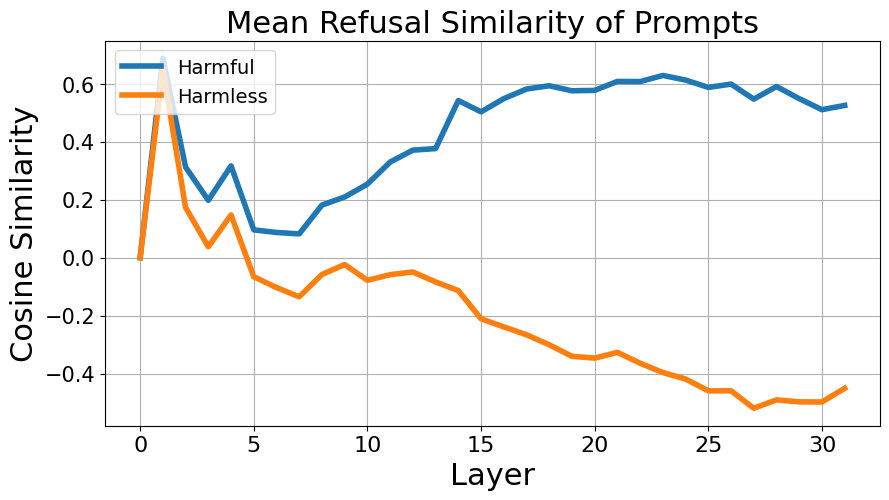

In [25]:
plot_refusal_similarity(refusal_direction_last, prompts_dict, batch_size=32)